In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8d66664c-a822-62b5-a5b0-d3292cd47c44)


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"  # NOTE: This is different from the Medium post!
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [3]:
!kaggle datasets download -d datamunge/sign-language-mnist

 78% 49.0M/62.6M [00:00<00:00, 103MB/s] 
100% 62.6M/62.6M [00:00<00:00, 128MB/s]


In [5]:
!unzip \sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [15]:
import csv
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

def extract_data(filename):

    with open(filename) as training_file:
        reader = csv.reader(training_file, delimiter=',')    
        imgs = []
        labels = []

        next(reader, None)
        
        for row in reader:
            label = row[0]
            data = row[1:]
            img = np.array(data).reshape((28, 28))

            imgs.append(img)
            labels.append(label)

        images = np.array(imgs).astype(float)
        labels = np.array(labels).astype(float)
            
    return images, labels


trainingImages, trainingLabels = extract_data('sign_mnist_train.csv')
testingImages, testingLabels = extract_data('sign_mnist_test.csv')

In [16]:
trainingImages = np.expand_dims(trainingImages, axis = 3)
testingImages = np.expand_dims(testingImages, axis = 3)

train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator( rescale =  1.0/255.0)

In [17]:
train_gen = train_datagen.flow( trainingImages, trainingLabels, batch_size = 64 )
val_gen = validation_datagen.flow( testingImages, testingLabels, batch_size = 64 )

In [22]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(26, activation='softmax'))

model.compile( optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               410112    
_________________________________________________________________
dense_3 (Dense)              (None, 26)               

In [23]:
history = model.fit_generator( train_gen, epochs = 30, validation_data = val_gen)
model.evaluate(testingImages, testingLabels)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
429/429 [==============================] - 8s 19ms/step - loss: 3.0286 - accuracy: 0.0968 - val_loss: 2.1067 - val_accuracy: 0.3005
Epoch 2/30
429/429 [==============================] - 8s 18ms/step - loss: 2.2131 - accuracy: 0.3043 - val_loss: 1.2959 - val_accuracy: 0.5733
Epoch 3/30
429/429 [==============================] - 8s 19ms/step - loss: 1.7727 - accuracy: 0.4333 - val_loss: 1.1098 - val_accuracy: 0.6120
Epoch 4/30
429/429 [==============================] - 8s 19ms/step - loss: 1.4769 - accuracy: 0.5212 - val_loss: 0.9216 - val_accuracy: 0.6874
Epoch 5/30
429/429 [==============================] - 8s 19ms/step - loss: 1.2769 - accuracy: 0.5829 - val_loss: 0.7490 - val_accuracy: 0.7557
Epoch 6/30
429/429 [==============================] - 8s 19ms/step - loss: 1.0938 - accuracy: 0.6475 - val_loss: 0.7917 - val_accuracy: 0.7474
Epoch 7/30
429/429 [==============================] - 8s 18ms/step - loss: 0.9963 - accuracy: 0.6716 - val_loss: 0.6456 - val_accuracy: 0.7800

[233.99154663085938, 0.6664807796478271]

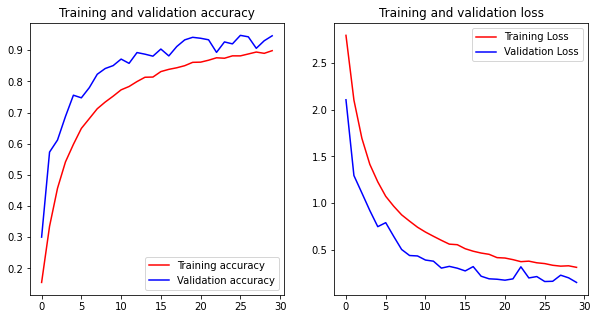

In [26]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()